# АВС-анализ ассортимента онлайн-магазина товаров для праздника


Вы работаете в крупном онлайн-магазине, который реализует товары «всё для праздников». Вам необходимо провести ABC-анализ и выявить наиболее важные товары на основе объемов продаж и популярности. Эта информация составит план закупок на весь следующий год.

**ABC-анализ** позволяет определить наиболее важные ресурсы компании на основе объемов продаж и прибыли.

В основе ABC-анализа лежит __«Принцип Парето»: 20% ресурсов приносят 80% прибыли__. Именно этот вид анализа позволяет выделить те самые  группы товаров, ресурсов, клиентов, поставщиков и т. п., которые и приносят компании основную прибыль.

__Задача анализа разделить товары на группы по принципу:__

- А — наиболее ценные, 20% — ассортимента; 80% — продаж
- В — промежуточные, 30% — ассортимента; 15% — продаж
- С — наименее ценные, 50% — ассортимента; 5% — продаж

## Что нужно сделать?

1. Выгрузить данные по продуктам из PostgreSQL
2. Посчитать, какой доход принес каждый продукт и сколько единиц каждого продукта было продано
3. Найти нарастающий итог в процентах по выручке и распределить товары в группы A, B и C по доходности
4. Найти нарастающий итог в процентах по количеству проданных единиц и распределить товары в группы A, B и C по популярности
5. Объединить группы, визуализировать и проанализировать результат
6. Выгрузить данные для отправки в отдел закупок

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

## Задание 1. Выгрузка данных по продуктам из PostgreSQL

**1. Импортируем файл с данными для подключения к БД.**

In [3]:
from postgresql_secret_hw import pg_secret

In [4]:
pg_secret

{'db_host': '178.154.254.133',
 'db_name': 'skyeng',
 'db_password': 'readonlyuser',
 'db_port': '5432',
 'db_user': 'readonlyuser'}

**2. Создаем соединение, в котором передаем данные доступа.**

In [5]:
connection = psycopg2.connect(
                             database=pg_secret['db_name'],
                             user=pg_secret['db_user'],
                             password=pg_secret['db_password'],
                             host=pg_secret['db_host'],
                             port=pg_secret['db_port'],
                             )

**3. Создаем объект cursor и передаем в него SQL запрос для получения всех данных из таблицы products.**

In [6]:
cursor = connection.cursor()

In [7]:
query = "SELECT * FROM products"

cursor.execute(query)

**4. Получаем все данные из объекта cursor и записываем их в датафрейм products.**

In [8]:
products = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

products.head()

,invoice_id,stock_code,description,quantity,price
0,546105,22551,PLASTERS IN TIN SPACEBOY,3,1.65
1,546105,22557,PLASTERS IN TIN VINTAGE PAISLEY,3,1.65
2,546105,22553,PLASTERS IN TIN SKULLS,3,1.65
3,546105,22554,PLASTERS IN TIN WOODLAND ANIMALS,3,1.65
4,546105,22556,PLASTERS IN TIN CIRCUS PARADE,4,1.65


**5. Изучим и почистим данные.**

In [9]:
# цена имеет строковый формат

products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   invoice_id   779495 non-null  int64 
 1   stock_code   779495 non-null  object
 2   description  779495 non-null  object
 3   quantity     779495 non-null  int64 
 4   price        779495 non-null  object
dtypes: int64(2), object(3)
memory usage: 29.7+ MB


In [10]:
# переведем цену в формат float

products = products.astype({'price': 'float64'})

products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoice_id   779495 non-null  int64  
 1   stock_code   779495 non-null  object 
 2   description  779495 non-null  object 
 3   quantity     779495 non-null  int64  
 4   price        779495 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 29.7+ MB


In [11]:
# в количестве и в цене есть очень большие числа

products.describe()

,invoice_id,quantity,price
count,779495.000000,779495.000000,779495.000000
mean,537427.005391,13.507085,3.218199
std,26901.961110,146.540284,29.674823
min,489434.000000,1.000000,0.000000
25%,514483.000000,2.000000,1.250000
50%,536754.000000,6.000000,1.950000
75%,562002.000000,12.000000,3.750000
max,581587.000000,80995.000000,10953.500000


In [12]:
# огромные количества не кажутся ошибочными, т.к. речь идет о мелких и недорогих товарах

products.sort_values(by='quantity', ascending=False).head(20)

,invoice_id,stock_code,description,quantity,price
318471,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08
742250,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04
381598,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,0.10
409499,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,0.10
409497,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,0.10
409500,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,0.10
292032,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,0.00
409498,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,0.10
415901,502269,21982,PACK OF 12 SUKI TISSUES,10000,0.25
415903,502269,21981,PACK OF 12 WOODLAND TISSUES,10000,0.25


In [13]:
# огромные цены идут по кодам с текстовыми значениями

products.sort_values(by='price', ascending=False).head(20)

,invoice_id,stock_code,description,quantity,price
415888,502263,M,Manual,1,10953.50
592419,524159,M,Manual,1,10468.80
368779,496115,M,Manual,1,8985.60
43182,551697,POST,POSTAGE,1,8142.75
411872,501768,M,Manual,1,6958.17
411788,501766,M,Manual,1,6958.17
231618,573080,M,Manual,1,4161.06
231617,573077,M,Manual,1,4161.06
218278,571751,M,Manual,1,3949.32
536492,517483,M,Manual,1,3610.50


In [14]:
# смотрим уникальные коды товаров

sorted(products['stock_code'].unique(), reverse=True)

['TEST002',
 'TEST001',
 'SP1002',
 'POST',
 'PADS',
 'M',
 'DOT',
 'D',
 'C2',
 'BANK CHARGES',
 'ADJUST2',
 'ADJUST',
 '90214Z',
 '90214Y',
 '90214W',
 '90214V',
 '90214U',
 '90214T',
 '90214S',
 '90214R',
 '90214P',
 '90214O',
 '90214N',
 '90214M',
 '90214L',
 '90214K',
 '90214J',
 '90214I',
 '90214H',
 '90214G',
 '90214F',
 '90214E',
 '90214D',
 '90214C',
 '90214B',
 '90214A',
 '90212C',
 '90212B',
 '90211B',
 '90211A',
 '90210D',
 '90210C',
 '90210B',
 '90210A',
 '90209C',
 '90209B',
 '90209A',
 '90208',
 '90206C',
 '90206A',
 '90205C',
 '90205A',
 '90204',
 '90203',
 '90202D',
 '90202C',
 '90202B',
 '90202A',
 '90201D',
 '90201C',
 '90201B',
 '90201A',
 '90200E',
 '90200D',
 '90200C',
 '90200B',
 '90200A',
 '90199D',
 '90199C',
 '90199B',
 '90199A',
 '90198B',
 '90198A',
 '90197D',
 '90197B',
 '90196B',
 '90196A',
 '90195B',
 '90195A',
 '90194',
 '90192',
 '90191',
 '90190C',
 '90190B',
 '90190A',
 '90189B',
 '90189A',
 '90188',
 '90187B',
 '90187A',
 '90186B',
 '90186A',
 '90185

In [15]:
# оставляем только те, что начинаются с буквы

text_codes = [code for code in products['stock_code'].unique() if code[0].isalpha()]

In [16]:
# смотрим более подробную информацию по текстовым кодам
# среди них доставка, банковские услуги, тестовые товары и др. 

products.loc[products['stock_code'].isin(text_codes)].groupby('stock_code')\
    .agg({'description':'max', 'price':'mean', 'invoice_id':'count'}).reset_index()

,stock_code,description,price,invoice_id
0,ADJUST,Adjustment by john on 26/01/2010 17,110.578750,32
1,ADJUST2,Adjustment by Peter on Jun 25 2010,243.683333,3
2,BANK CHARGES,Bank Charges,14.516129,31
3,C2,CARRIAGE,50.516129,248
4,D,Discount,41.378000,5
5,DOT,DOTCOM POSTAGE,744.147500,16
6,M,Manual,212.600567,688
7,PADS,PADS TO MATCH ALL CUSHIONS,0.000000,18
8,POST,POSTAGE,29.938874,1803
9,SP1002,KID'S CHALKBOARD/EASEL,2.950000,2


In [17]:
# убираем строки с тектовыми кодами из датасета

selected_codes = set(products['stock_code']) - set(text_codes)

products = products.loc[products['stock_code'].isin(selected_codes)]

products

,invoice_id,stock_code,description,quantity,price
0,546105,22551,PLASTERS IN TIN SPACEBOY,3,1.65
1,546105,22557,PLASTERS IN TIN VINTAGE PAISLEY,3,1.65
2,546105,22553,PLASTERS IN TIN SKULLS,3,1.65
3,546105,22554,PLASTERS IN TIN WOODLAND ANIMALS,3,1.65
4,546105,22556,PLASTERS IN TIN CIRCUS PARADE,4,1.65
...,...,...,...,...,...
779490,546105,20974,12 PENCILS SMALL TUBE SKULL,3,0.65
779491,546105,20975,12 PENCILS SMALL TUBE RED RETROSPOT,3,0.65
779492,546105,20973,12 PENCIL SMALL TUBE WOODLAND,6,0.65
779493,546105,22861,EASTER TIN CHICKS IN GARDEN,1,1.65


## Задание 2. Подсчет выручки и количества проданных единиц по товарам

**1. Считаем выручку по каждому товару.**

In [18]:
products['total'] = products.quantity * products.price

products_total_sum = products.groupby(products.stock_code)['total'].sum().reset_index()

products_total_sum.rename(columns={'total': 'total_sum'}, inplace=True) # переименовываем столбец с суммарной выручкой

products_total_sum.head()

,stock_code,total_sum
0,10002,6638.27
1,10080,124.61
2,10109,1.68
3,10120,136.08
4,10123C,226.76


**2. Считаем количество проданных единиц по каждому товару.**

In [19]:
products_total_num = products.groupby(products.stock_code)['quantity'].sum().reset_index()

products_total_num.rename(columns={'quantity': 'total_num'}, inplace=True) # переименовываем столбец с суммарным количеством

products_total_num.head()

,stock_code,total_num
0,10002,8479
1,10080,303
2,10109,4
3,10120,648
4,10123C,628


**3. Объединяем полученные данные в общую таблицу.**

In [20]:
products_total = pd.merge(products_total_sum,
                          products_total_num,
                          on='stock_code',
                          how='inner'
                         )
products_total.head()

,stock_code,total_sum,total_num
0,10002,6638.27,8479
1,10080,124.61,303
2,10109,1.68,4
3,10120,136.08,648
4,10123C,226.76,628


## Задание 3. Присвоение категорий A, B, C по выручке

**1. Сортируем дата-фрейм по убыванию.**

In [21]:
products_total = products_total.sort_values(by='total_sum', ascending=False)

products_total.head()

,stock_code,total_sum,total_num
1609,22423,277656.25,24139
4080,85123A,247203.36,91814
2726,23843,168469.60,80995
4058,85099B,167920.64,93436
3819,84879,124351.86,78234


**2. Находим процент от общей выручки для каждого товара.**

In [22]:
grand_total_sum = products_total.total_sum.sum()

products_total['rev_share'] = products_total.total_sum / grand_total_sum * 100

products_total.head()

,stock_code,total_sum,total_num,rev_share
1609,22423,277656.25,24139,1.626711
4080,85123A,247203.36,91814,1.448296
2726,23843,168469.60,80995,0.987017
4058,85099B,167920.64,93436,0.983800
3819,84879,124351.86,78234,0.728543


**3. Находим кумулятивную сумму по процентам от общей выручки.**

In [23]:
products_total['rev_share_cum'] = products_total.rev_share.cumsum()

products_total

,stock_code,total_sum,total_num,rev_share,rev_share_cum
1609,22423,277656.25,24139,1.626711,1.626711
4080,85123A,247203.36,91814,1.448296,3.075007
2726,23843,168469.60,80995,0.987017,4.062023
4058,85099B,167920.64,93436,0.983800,5.045824
3819,84879,124351.86,78234,0.728543,5.774367
...,...,...,...,...,...
3778,84845A,1.25,1,0.000007,99.999983
2875,35976B,1.25,1,0.000007,99.999991
247,20721,0.85,1,0.000005,99.999996
3419,84205C,0.38,2,0.000002,99.999998


**4. С помощью функции присваиваем каждому товару категорию A, B или C по выручке.**

In [24]:
def category(x):
    if x <= 80:
        return 'A'
    elif x <= 95:
        return 'B'
    else:
        return 'C'

In [25]:
products_total['revenue'] = products_total['rev_share_cum'].apply(category)

products_total = products_total.iloc[:, [0, 2, 5]]

products_total

# products_total.loc[products_total['revenue'] == 'B']

,stock_code,total_num,revenue
1609,22423,24139,A
4080,85123A,91814,A
2726,23843,80995,A
4058,85099B,93436,A
3819,84879,78234,A
...,...,...,...
3778,84845A,1,C
2875,35976B,1,C
247,20721,1,C
3419,84205C,2,C


## Задание 4. Присвоение категорий A, B, C по количеству проданных единиц

**1. Сортируем дата-фрейм по убыванию.**

In [26]:
products_total = products_total.sort_values(by='total_num', ascending=False)

products_total

,stock_code,total_num,revenue
3410,84077,105185,A
4058,85099B,93436,A
4080,85123A,91814,A
601,21212,89850,A
2726,23843,80995,A
...,...,...,...
4337,90055,1,C
3052,47554,1,C
3199,72751C,1,C
3143,71434B,1,C


**2. Находим процент от общего количества проданных единиц для каждого товара.**

In [27]:
grand_total_num = products_total.total_num.sum()

products_total['quan_share'] = products_total.total_num / grand_total_num * 100

products_total.head()

,stock_code,total_num,revenue,quan_share
3410,84077,105185,A,1.000479
4058,85099B,93436,A,0.888727
4080,85123A,91814,A,0.873299
601,21212,89850,A,0.854618
2726,23843,80995,A,0.770393


**3. Находим кумулятивную сумму по процентам от общего количества проданных единиц.**

In [28]:
products_total['quan_share_cum'] = products_total.quan_share.cumsum()

products_total

,stock_code,total_num,revenue,quan_share,quan_share_cum
3410,84077,105185,A,1.000479,1.000479
4058,85099B,93436,A,0.888727,1.889205
4080,85123A,91814,A,0.873299,2.762504
601,21212,89850,A,0.854618,3.617122
2726,23843,80995,A,0.770393,4.387515
...,...,...,...,...,...
4337,90055,1,C,0.000010,99.999962
3052,47554,1,C,0.000010,99.999971
3199,72751C,1,C,0.000010,99.999981
3143,71434B,1,C,0.000010,99.999990


**4. С помощью функции присваиваем каждому товару категорию A, B или C по количеству проданных единиц.**

In [29]:
products_total['popularity'] = products_total['quan_share_cum'].apply(category)

products_total = products_total.iloc[:,[0, 2, 5]]

products_total

,stock_code,revenue,popularity
3410,84077,A,A
4058,85099B,A,A
4080,85123A,A,A
601,21212,A,A
2726,23843,A,A
...,...,...,...
4337,90055,C,C
3052,47554,C,C
3199,72751C,C,C
3143,71434B,C,C


## Задание 5. Визуализация и оценка результата

**1. Подготовим датасет для визуализации.**

In [30]:
abc_description = products_total.copy()

# создаем словари с текстовыми расшифровками буквенных категорий

revenue_dict = {"A": "A (наиболее доходные)", 'B': "B (средне доходные)", 'C': "C (наименее доходные)"}
popularity_dict = {'A': "A (наиболее популярные)",'B': "B (средне популярные)", 'C': "C (наименее популярные)"}

# заменяем буквенные категории на их значения из словарей

abc_description['revenue'] = abc_description['revenue'].map(revenue_dict)
abc_description['popularity'] = abc_description['popularity'].map(popularity_dict)

In [31]:
# делаем группировку и считаем значения

abc = abc_description.groupby(['revenue', 'popularity'], as_index=False)['stock_code'].count()

abc

,revenue,popularity,stock_code
0,A (наиболее доходные),A (наиболее популярные),690
1,A (наиболее доходные),B (средне популярные),252
2,A (наиболее доходные),C (наименее популярные),59
3,B (средне доходные),A (наиболее популярные),265
4,B (средне доходные),B (средне популярные),577
5,B (средне доходные),C (наименее популярные),380
6,C (наименее доходные),A (наиболее популярные),71
7,C (наименее доходные),B (средне популярные),298
8,C (наименее доходные),C (наименее популярные),2027


In [32]:
# создаем сводную таблицу

abc_pivot = abc.pivot(index="revenue", 
                      columns="popularity", 
                      values="stock_code"
                     ).reset_index()

abc_pivot = abc_pivot.set_index('revenue')

abc_pivot

popularity,A (наиболее популярные),B (средне популярные),C (наименее популярные)
revenue,,,
A (наиболее доходные),690,252,59
B (средне доходные),265,577,380
C (наименее доходные),71,298,2027


**2. Построим тепловую карту.**

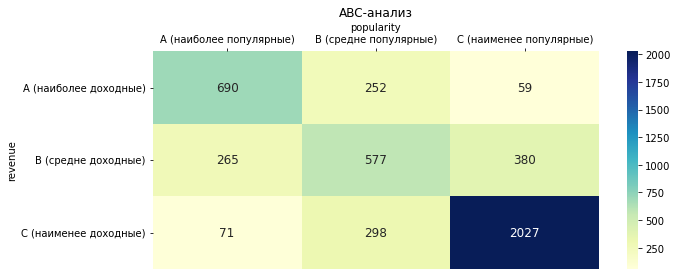

In [33]:
f, ax = plt.subplots(figsize=(10, 4)) # создаем фигуру и оси
                     
sns.heatmap(abc_pivot, 
            annot=True,
            cmap="YlGnBu",
            fmt='g',
            annot_kws={'size':12}) # размер шрифта в ячейках
            
plt.title("ABC-анализ")            

plt.yticks(rotation=0) # угол подписей
ax.xaxis.set_ticks_position('top') # подписи колонок наверху
ax.xaxis.set_label_position('top') # подпись оси x наверху
            
plt.ylabel("revenue")
plt.xlabel("popularity")

plt.show()

**3. Делаем выводы по результатам.**

Товары в самой обширной группе CC непопулярны и приносят малую часть выручки, имеет смысл сократить закупки этих товаров и возможно отказаться от части ассмортимента. При составлении плана закупок нужно сосредоточиться на группе AA, в которой собраны товары, находящиеся в топе по выручке и популярности.

## Задание 6. Выгрузка данных для отправки

**1. Готовим данные с уникальными stock_code и description из исходной таблицы.**

In [34]:
# в исходной таблице на 4619 уникальных stock_code приходится 5270 уникальных description

products_table = products[['stock_code', 'description']].drop_duplicates()

products_table.nunique()

stock_code     4619
description    5270
dtype: int64

In [35]:
# в финальной таблице с категориями 4619 уникальных stock_code

products_total['stock_code'].count()

4619

**2. Посмотрим подробнее и description из исходной таблицы.**

In [36]:
# в данных для некоторых stock_code существует до 4х разных description 

products_table = products[['stock_code', 'description']].drop_duplicates()

descr_count = products_table.groupby('stock_code')['description'].count().reset_index()

descr_count = descr_count.loc[descr_count['description'] > 1].sort_values(by='description', ascending=False)

descr_count

,stock_code,description
219,20685,4
2353,23196,4
1541,22345,4
2393,23236,4
1540,22344,4
...,...,...
1593,22407,2
1594,22408,2
1595,22409,2
1596,22410,2


In [37]:
# видно, что по сути description не отличаются, можно оставить один из вариантов

descr_codes = descr_count['stock_code'][:5]

products_table.loc[products_table['stock_code'].isin(descr_codes)].sort_values(by='stock_code')

,stock_code,description
131,20685,DOORMAT RED RETROSPOT
399592,20685,DOORMAT RED SPOT
356259,20685,DOOR MAT RED SPOT
319424,20685,RED SPOTTY COIR DOORMAT
324131,22344,PARTY PIZZA DISH PINK WHITE SPOT
321634,22344,PARTY PIZZA DISH PINK+WHITE SPOT
441623,22344,PARTY PIZZA DISH PINK RETROSPOT
3337,22344,PARTY PIZZA DISH PINK POLKADOT
430107,22345,PARTY PIZZA DISH BLUE RETROSPOT
321636,22345,PARTY PIZZA DISH BLUE+WHITE SPOT


In [38]:
# оставляем по одному description на stock_code

products_table = products.groupby('stock_code')['description'].min().reset_index()

products_table

,stock_code,description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10109,BENDY COLOUR PENCILS
3,10120,DOGGY RUBBER
4,10123C,HEARTS WRAPPING TAPE
...,...,...
4614,90214U,"LETTER ""U"" BLING KEY RING"
4615,90214V,"LETTER ""V"" BLING KEY RING"
4616,90214W,"LETTER ""W"" BLING KEY RING"
4617,90214Y,"LETTER ""Y"" BLING KEY RING"


**2. Объединяем таблицы и записываем полученный датасет в файл для отправки.**

In [39]:
# создаем столбец с оъединенной категорией

products_total['group'] = products_total['revenue'] + products_total['popularity']

products_total

,stock_code,revenue,popularity,group
3410,84077,A,A,AA
4058,85099B,A,A,AA
4080,85123A,A,A,AA
601,21212,A,A,AA
2726,23843,A,A,AA
...,...,...,...,...
4337,90055,C,C,CC
3052,47554,C,C,CC
3199,72751C,C,C,CC
3143,71434B,C,C,CC


In [40]:
# объединяем данные из двух таблиц

abc_table = products_total[['stock_code', 'group']]

abc_products = pd.merge(products_table,
                        abc_table,
                        on='stock_code',
                        how='inner'
                       )

abc_products

,stock_code,description,group
0,10002,INFLATABLE POLITICAL GLOBE,AA
1,10080,GROOVY CACTUS INFLATABLE,CC
2,10109,BENDY COLOUR PENCILS,CC
3,10120,DOGGY RUBBER,CC
4,10123C,HEARTS WRAPPING TAPE,CC
...,...,...,...
4614,90214U,"LETTER ""U"" BLING KEY RING",CC
4615,90214V,"LETTER ""V"" BLING KEY RING",CC
4616,90214W,"LETTER ""W"" BLING KEY RING",CC
4617,90214Y,"LETTER ""Y"" BLING KEY RING",CC


In [41]:
# записываем данные в csv файл

abc_products.to_csv('abc_products.csv', index=False)